In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymongo
import time

from PIL import Image
from pprint import pprint
from wordcloud import WordCloud

%matplotlib inline

# Conexão com o MongoDB

In [2]:
client = pymongo.MongoClient()
db = client['8M2020']  
collection = db.tweets_updated

# Funções

In [3]:
def query(collection: pymongo.collection.Collection, pipeline: list) -> list:
    query = list(collection.aggregate(pipeline, allowDiskUse=True))
    return query

In [4]:
def get_language(lang: str) -> str:
    bcp_lang = pd.read_csv('bcp47.csv')
    language = bcp_lang[bcp_lang['lang'] == lang]['language'].tolist()[0]
    return language

In [5]:
def get_hashtag_by_lang(collection: pymongo.collection.Collection, lang: str) -> list:
    pipeline = [
        {
            '$match': {
                'lang': lang
            }
        }, {
            '$project': {
                '_id': 0,
                'id': 1,
                'retweeted_status': {
                    '$ifNull': [
                        '$entities.hashtags.text', 
                        '$retweeted_status.extended_tweet.entities.hashtags.text'
                    ]
                }
            }
        }, {
            '$project': {
                'hashtags': '$retweeted_status'
            }
        }, {
            '$unwind': {
                'path': '$hashtags'
            }
        }, {
            '$group': {
                '_id': '$hashtags',
                'count': {
                    '$sum': 1
                }
            }
        }, {
            '$sort': {
                'count': -1
            }
        }
    ]
    
    document = list(collection.aggregate(pipeline=pipeline))
    return document

# Estatísticas

## Idiomas

In [6]:
pipeline1 = [
    {
        '$group': {
            '_id': '$lang',
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [7]:
languages = query(collection=collection, pipeline=pipeline1)

In [8]:
num_languages = len(languages)
print(f'Número de idiomas presentes na base: {num_languages}')

Número de idiomas presentes na base: 64


In [9]:
languages_df = pd.DataFrame(languages)
languages_df.rename(columns={"_id": "language"}, inplace=True)
languages_df['language'] = languages_df['language'].apply(get_language)
languages_df.head(10)

,language,count
0,English,1991792
1,Spanish,1898572
2,Undefined,395007
3,Portuguese,274636
4,French,192670
5,Hindi,162007
6,Turkish,156428
7,Arabic,106742
8,Catalan,55218
9,Indonesian,53962


In [10]:
# languages_df.to_parquet('languages.parquet.gzip', compression='gzip')
# languages_df = pd.read_parquet('languages.parquet.gzip')

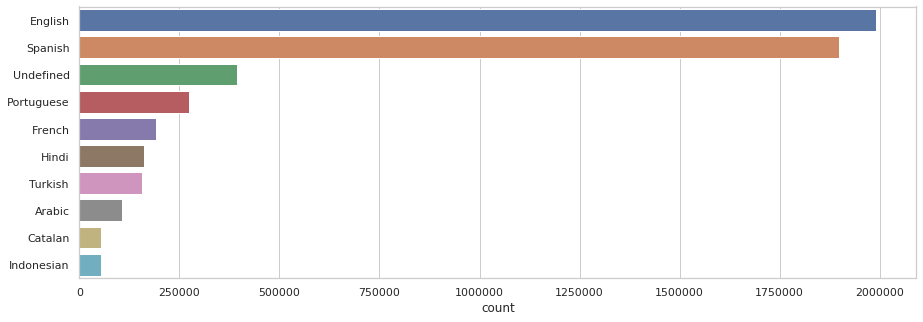

In [11]:
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='language', data=languages_df[0:10])
ax.set_ylabel('')
plt.show()

## Hashtags

In [12]:
pipeline2 = [
    {
        '$project': {
            '_id': 0, 
            'id': 1, 
            'retweeted_status': {
                '$ifNull': [
                    '$entities.hashtags.text', 
                    '$retweeted_status.extended_tweet.entities.hashtags.text'
                ]
            }
        }
    }, {
        '$project': {
            'hashtag': '$retweeted_status'
        }
    }, {
        '$unwind': {
            'path': '$hashtag'
        }
    }, {
        '$group': {
            '_id': '$hashtag', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [13]:
hashtags = query(collection=collection, pipeline=pipeline2)

In [14]:
num_hashtags = len(hashtags)
print(f'Número de hashtags presentes na base: {num_hashtags}')

Número de hashtags presentes na base: 249448


In [15]:
hashtags_df = pd.DataFrame(hashtags)
hashtags_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_df.head(10)

,hashtag,count
0,InternationalWomensDay,827798
1,8M,419948
2,8M2020,390969
3,IWD2020,314204
4,DiaInternacionalDeLaMujer,278927
5,HappyWomensDay2020,191408
6,Marcha8M,171261
7,WomensDay,160403
8,DiaDeLaMujer,111216
9,8martdunyakadinlargunu,89214


In [16]:
# hashtags_df.to_parquet('hashtags.parquet.gzip', compression='gzip')
# hashtags_df = pd.read_parquet('hashtags.parquet.gzip')

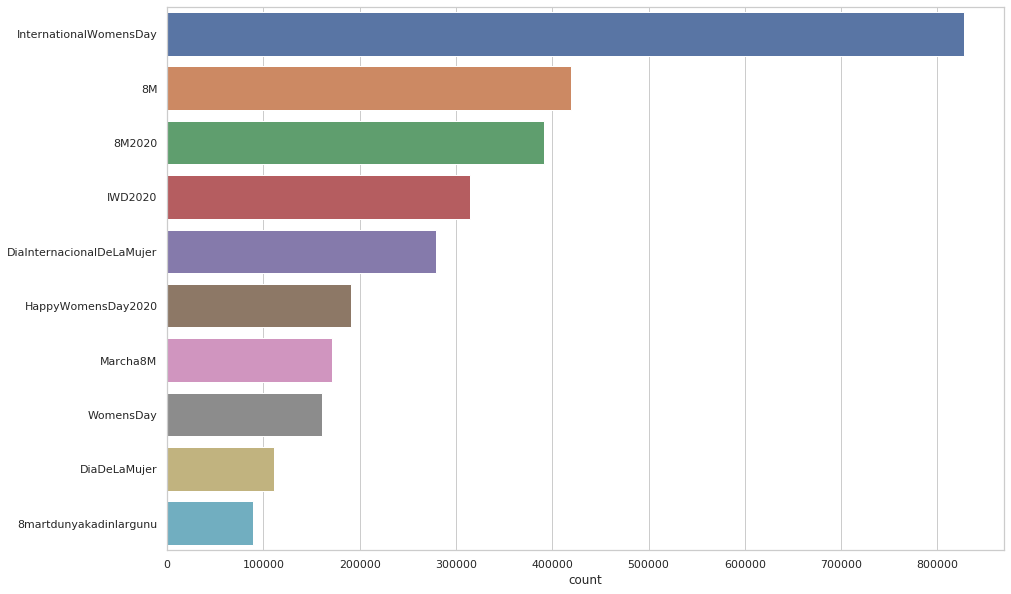

In [17]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_df[0:10])
ax.set_ylabel('')
plt.show()

### Hashtags por idioma do tweets

In [18]:
hashtags_en = get_hashtag_by_lang(lang='en', collection=collection)
hashtags_es = get_hashtag_by_lang(lang='es', collection=collection)
hashtags_pt = get_hashtag_by_lang(lang='pt', collection=collection)

In [19]:
hashtags_en_df = pd.DataFrame(hashtags_en)
hashtags_en_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_en_df.head(10)

,hashtag,count
0,InternationalWomensDay,606004
1,IWD2020,266906
2,WomensDay,104116
3,HappyWomensDay2020,97902
4,EachforEqual,41491
5,internationalwomensday,31531
6,IWD,26554
7,InternationalWomenDay2020,24085
8,MaguvaMaguva,20493
9,GenerationEquality,19672


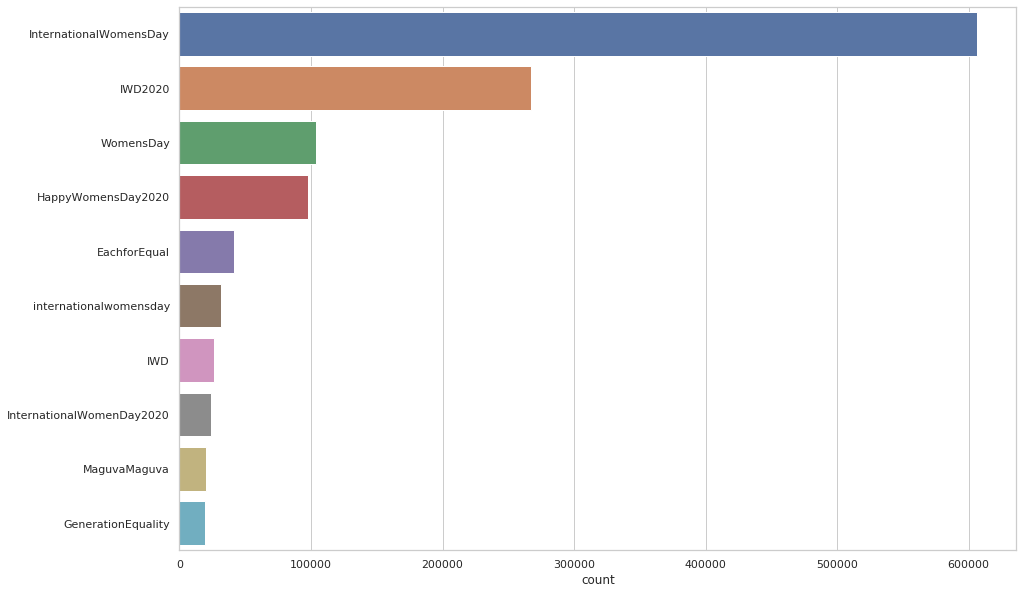

In [23]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_en_df[0:10])
ax.set_ylabel('')
plt.show()

In [20]:
hashtags_es_df = pd.DataFrame(hashtags_es)
hashtags_es_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_es_df.head(10)

,hashtag,count
0,8M,339063
1,8M2020,284662
2,DiaInternacionalDeLaMujer,239545
3,Marcha8M,151838
4,DiaDeLaMujer,91310
5,NiUnaMenos,41491
6,8Marzo,30031
7,MarchaFeminista,26667
8,DíaInternacionalDeLaMujer,23320
9,8m,22850


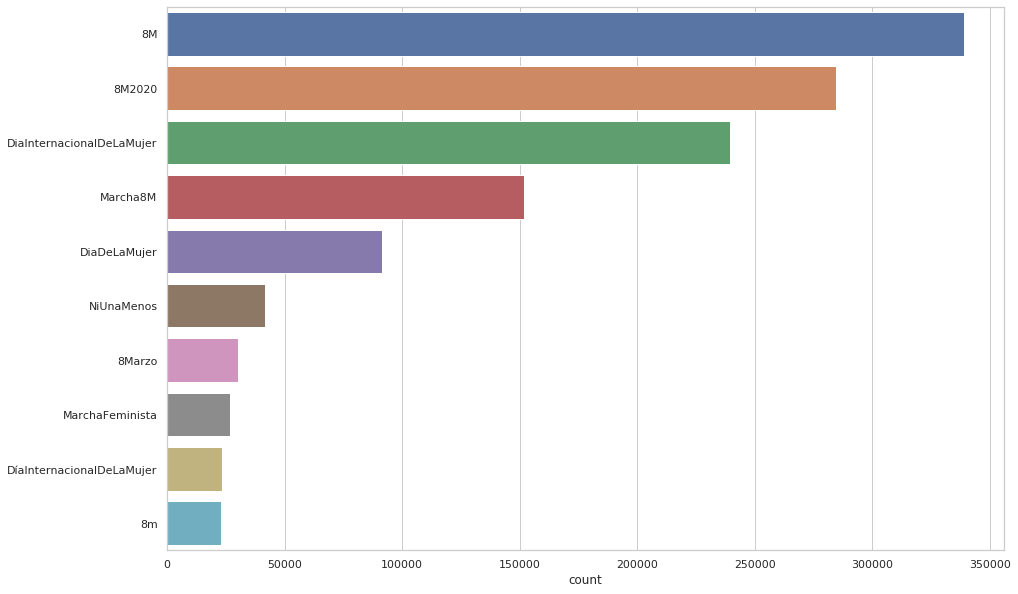

In [24]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_es_df[0:10])
ax.set_ylabel('')
plt.show()

In [21]:
hashtags_pt_df = pd.DataFrame(hashtags_pt)
hashtags_pt_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_pt_df.head(10)

,hashtag,count
0,diadasmulheres,41981
1,DiaDaMulher,17103
2,8M2020,15023
3,8M,13465
4,InternationalWomensDay,11076
5,diadamulher,4162
6,DiaDasMulheres,2036
7,DiaInternacionalDaMulher,1391
8,MulheresComBolsonaro,1123
9,8m,1009


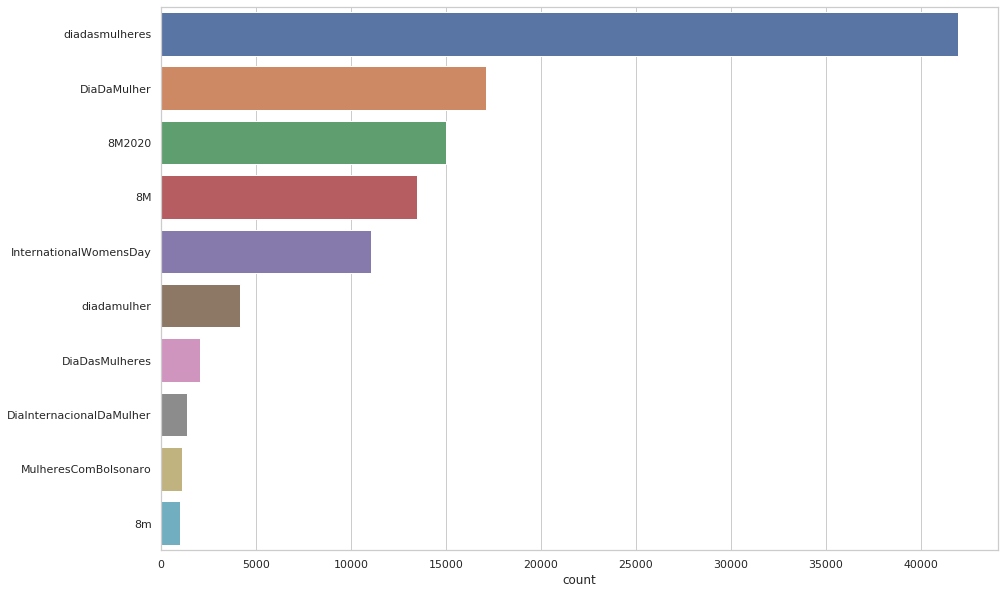

In [25]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_pt_df[0:10])
ax.set_ylabel('')
plt.show()

In [22]:
hashtags_en_df.to_parquet('hashtags_en.parquet.gzip', compression='gzip')
hashtags_es_df.to_parquet('hashtags_es.parquet.gzip', compression='gzip')
hashtags_pt_df.to_parquet('hashtags_pt.parquet.gzip', compression='gzip')

# hashtags_en_df = pd.read_parquet('hashtags_en.parquet.gzip')
# hashtags_es_df = pd.read_parquet('hashtags_es.parquet.gzip')
# hashtags_pt_df = pd.read_parquet('hashtags_pt.parquet.gzip')

## Tweets ao longo do tempo

In [6]:
pipeline3 = [
    {
        '$project': {
            'date': {
                '$dateFromString': {
                    'dateString': '$created_at'
                }
            }
        }
    }, {
        '$project': {
            'date': {
                '$dateToString': {
                    'format': '%d/%m %H:00', 
                    'date': '$date'
                }
            }
        }
    }, {
        '$group': {
            '_id': '$date', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
]

In [7]:
tweets_times = query(collection=collection, pipeline=pipeline3)

In [8]:
tweets_times_df = pd.DataFrame(tweets_times)
tweets_times_df.rename(columns={"_id": "data_hora"}, inplace=True)
tweets_times_df['cumsum'] = tweets_times_df['count'].cumsum()
tweets_times_df.head(10)

,data_hora,count,cumsum
0,07/03 21:00,2,2
1,07/03 22:00,31858,31860
2,07/03 23:00,34284,66144
3,08/03 00:00,33429,99573
4,08/03 01:00,37691,137264
5,08/03 02:00,56392,193656
6,08/03 03:00,91797,285453
7,08/03 04:00,124228,409681
8,08/03 05:00,133609,543290
9,08/03 06:00,141349,684639


In [71]:
data = lambda x: x[:5]
hora = lambda x: x[6:]

In [77]:
tweets_times_df['data'] = tweets_times_df.data_hora.apply(data)
tweets_times_df['hora'] = tweets_times_df.data_hora.apply(hora)

In [78]:
tweets_times_df.head()

,data_hora,count,cumsum,data,hora
0,07/03 21:00,2,2,07/03,21:00
1,07/03 22:00,31858,31860,07/03,22:00
2,07/03 23:00,34284,66144,07/03,23:00
3,08/03 00:00,33429,99573,08/03,00:00
4,08/03 01:00,37691,137264,08/03,01:00


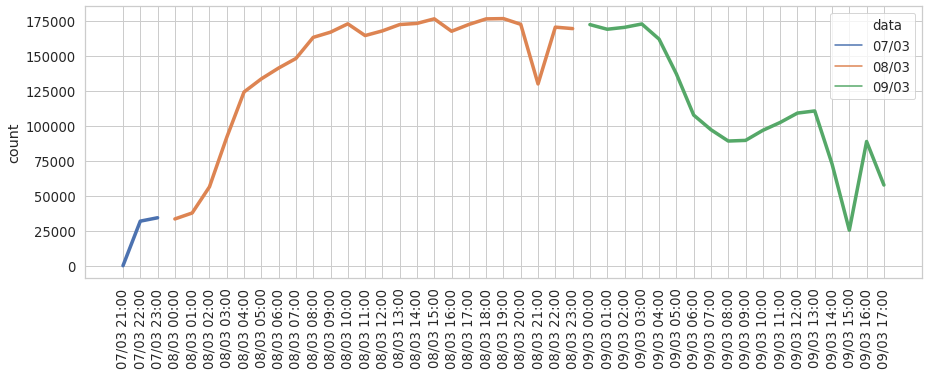

In [81]:
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)
ax = sns.lineplot(data=tweets_times_df, x="data_hora", y="count", hue="data", linewidth=3.5,)
plt.xticks(rotation=90)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
# ax.tick_params(axis='x', colors='black')
plt.show()

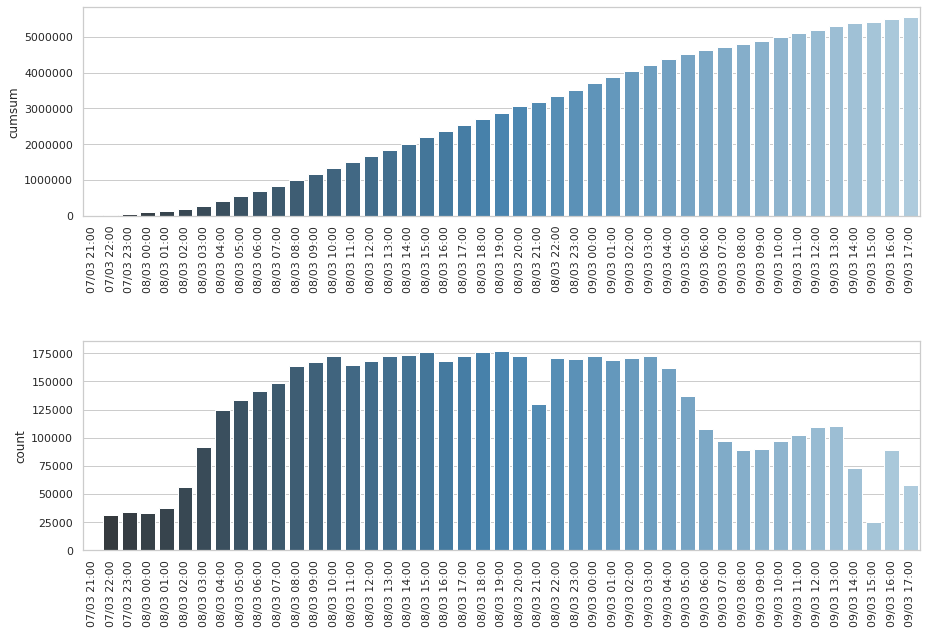

In [29]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))

sns.barplot(x='data_hora', 
            y='cumsum', 
            data=tweets_times_df, 
            ax=ax1, 
            palette="Blues_d")

sns.barplot(x='data_hora', 
            y='count', 
            data=tweets_times_df, 
            ax=ax2, 
            palette="Blues_d")

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel('')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel('')

plt.subplots_adjust(hspace=0.6)
plt.show()

## Perfis

In [30]:
pipeline4 = [
    {
        '$project': {
            '_id': 0, 
            'created_at': {
                '$dateFromString': {
                    'dateString': '$user.created_at'
                }
            }, 
            'id': '$user.id_str', 
            'screen_name': '$user.screen_name', 
            'name': '$user.name', 
            'tweet_count': '$user.statuses_count', 
            'fav_count': '$user.favourites_count', 
            'followers': '$user.followers_count', 
            'following': '$user.friends_count'
        }
    }, {
        '$project': {
            'date_creation': {
                '$dateToString': {
                    'format': '%d/%m/%Y', 
                    'date': '$created_at'
                }
            }, 
            'id': 1, 
            'screen_name': 1, 
            'name': 1, 
            'tweet_count': 1, 
            'fav_count': 1, 
            'followers': 1, 
            'following': 1
        }
    }, {
        '$group': {
            '_id': '$id', 
            'date_creation': {
                '$first': '$date_creation'
            }, 
            'screen_name': {
                '$first': '$screen_name'
            }, 
            'name': {
                '$first': '$name'
            }, 
            'tweet_count': {
                '$first': '$tweet_count'
            }, 
            'fav_count': {
                '$first': '$fav_count'
            }, 
            'followers': {
                '$first': '$followers'
            }, 
            'following': {
                '$first': '$following'
            }, 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [31]:
perfis = query(collection=collection, pipeline=pipeline4)

In [32]:
num_perfis = len(perfis)
print(f'Número de perfis presentes na base: {num_perfis}')

Número de perfis presentes na base: 2765487


In [33]:
perfis_df = pd.DataFrame(perfis)

In [34]:
perfis_df.head(10)

,_id,date_creation,screen_name,name,tweet_count,fav_count,followers,following,count
0,1143528514550927361,25/06/2019,femtech_,FemTech_🖥👩🏽‍💻,451838,37,10915,1,1970
1,2288134782,12/01/2014,EngrKumbhakar,rajesh kumbhakar,44686,38009,296,515,731
2,2853199524,12/10/2014,VBInsan1,V B Bansal,971686,3910,2244,2126,545
3,2325964293,05/02/2014,tyagi40,Dr.Rajneesh Tyagi,812606,0,6655,0,534
4,1017637448472391680,13/07/2018,imVicky_insan,Vikram insan 🇮🇳,274851,210060,1128,496,528
5,1122535081615060993,28/04/2019,NidhiKa89393815,Nidhi Kashyap,19621,16660,471,626,521
6,850980725407068160,09/04/2017,RameshG1509,Ramesh Gandhi,282115,223175,4786,1742,465
7,716096097358209024,02/04/2016,deepak_mragwani,Deepak_mragwani,277137,215058,9254,5354,464
8,241458756,22/01/2011,IndRenaissance1,𝐍𝐞𝐨-𝐒𝐨𝐜𝐢𝐚𝐥 𝐑𝐞𝐟𝐨𝐫𝐦 (𝐂𝐨𝐯𝐢𝐝-𝟏𝟗),22998,10988,161,5137,461
9,721669117032402948,17/04/2016,sanju_gouda,🚩Sanju Gouda🚩,119924,81967,2359,2255,460


## Tweets

In [35]:
pipeline5 = [
    {
        '$project': {
            'tweet_id': '$id_str', 
            'date': {
                '$dateFromString': {
                    'dateString': '$created_at'
                }
            }, 
            'author': '$user.screen_name',
            'tweet_text': {
                '$ifNull': [
                    '$retweeted_status.full_text', '$full_text'
                ]
            }, 
            'language': '$lang',
            'num_likes': '$favorite_count', 
            'num_retweets': '$retweet_count', 
            'quoted_status_id': {
                '$ifNull': [
                    '$quoted_status_id_str', None
                ]
            }, 
            'retweeted_status_id': {
                '$ifNull': [
                    '$retweeted_status.id_str', None
                ]
            }, 
            'reply_to_user': {
                '$ifNull': [
                    '$in_reply_to_user_id_str', None
                ]
            }, 
            'reply_to_status': {
                '$ifNull': [
                    '$in_reply_to_status_id_str', None
                ]
            } 
        }
    }, {
        '$project': {
            '_id': 0, 
            'tweet_id': 1, 
            'date': {
                '$dateToString': {
                    'format': '%d/%m/%Y %H:%M:%S', 
                    'date': '$date'
                }
            }, 
            'author': 1,
            'tweet_text': 1, 
            'language': 1,
            'num_likes': 1, 
            'num_retweets': 1, 
            'quoted_status_id': 1, 
            'retweeted_status_id': 1, 
            'reply_to_user': 1, 
            'reply_to_status': 1
        }
    }
]

In [36]:
tweets = query(collection=collection, pipeline=pipeline5)

In [37]:
tweets[0]

{'tweet_id': '1236411306200174592',
 'author': 'danismanoz',
 'tweet_text': "🔷 #8M Görüldü'nün gözünden \n\n🔺İnadına İsyan İnadına Özgürlük: Kadın\n\n📎 Tamamı: https://t.co/Y5erz0MDyt https://t.co/w8ntmdXzuN",
 'language': 'tr',
 'num_likes': 0,
 'num_retweets': 5,
 'quoted_status_id': None,
 'retweeted_status_id': '1236399729593942017',
 'reply_to_user': None,
 'reply_to_status': None,
 'date': '07/03/2020 22:00:01'}

In [38]:
num_tweets = len(tweets)
print(f'Documentos presentes na base: {num_tweets}')

Documentos presentes na base: 5558171


In [39]:
tweets_df = pd.DataFrame(tweets)

In [40]:
tweets_df.head(10)

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
0,1236411306200174592,danismanoz,🔷 #8M Görüldü'nün gözünden \n\n🔺İnadına İsyan ...,tr,0,5,None,1236399729593942017,None,None,07/03/2020 22:00:01
1,1236411302693801984,PCI_Unimelb,Essential reading for all of us working in dat...,en,17,10,None,None,None,None,07/03/2020 22:00:00
2,1236411304237285377,00agent21,Women. Are. Amazing. At 7 months pregnant I st...,en,0,41,None,1236410293011582977,None,None,07/03/2020 22:00:00
3,1236411303364833280,FM1061,This weekend is #IWD2020 and we’ve got the @Wo...,en,4,2,None,None,None,None,07/03/2020 22:00:00
4,1236411302895124487,GovernoMA,"Sol com cara O projeto Inclusive, Praia! está ...",pt,8,2,None,None,None,None,07/03/2020 22:00:00
5,1236411301213147139,excitonscience,"Centre members Yvonne Hora, Boer Tan and Eliza...",en,12,2,None,None,None,None,07/03/2020 22:00:00
6,1236411302286888963,DatamosMx,Rumbo al #8M | Usuarios de redes sociales conv...,es,0,0,None,None,None,None,07/03/2020 22:00:00
7,1236411302152634368,AFL,Happy International Women's Day 💜 #IWD2020\n\n...,en,104,9,None,None,None,None,07/03/2020 22:00:00
8,1236411300894425088,footballnsw,Here's to strong women.\nMay we know them.\nMa...,en,19,1,None,None,None,None,07/03/2020 22:00:00
9,1236411287564718080,noah_sbyard,Happy #IWD2020 to everyone marching and campai...,en,0,22,None,1236403525908754433,None,None,07/03/2020 21:59:57


In [47]:
tweets_df.to_parquet('tweets.parquet.gzip', compression='gzip')

### Frequência

In [41]:
num_unique_tweets = len(tweets_df['tweet_text'].value_counts())
num_unique_tweets

1276118

In [42]:
text_df = pd.DataFrame(tweets_df['tweet_text'].value_counts(
).rename_axis('unique_values').reset_index(name='counts'))

pd.set_option('display.max_colwidth', None)
text_df.head(10)

,unique_values,counts
0,#InternationalWomensDay https://t.co/MgT8Df2IAV,39091
1,E o motorista do 630 que todo ano na semana do dia internacional da mulher enfeita o ônibus todo e dar uma lembrancinha para todas as mulheres que entram no ônibus 😍😍❤️❤️😭 https://t.co/SNSfrNM6L6,18798
2,"""8 de março de 1857, morreram aproximadamente 130 mulheres carbonizadas quando foram trancadas na fábrica de tecelagem, em Nova York, onde trabalhavam, por estarem em greve. Em homenagem a essas mulheres, em 1910, declarou-se o dia 8 de março como o ""Dia Internacional da Mulher"". https://t.co/VyABZO6WrU",17188
3,"Today is #InternationalWomensDay and we recognise that women are still far from equal to men in today’s societies.\nWe can not have climate justice without gender equity.\n\nAnd remember; what we women want today - and every day- is equality, not congratulations or celebrations. https://t.co/g1CuEN6YLX",15848
4,Berpendidikan tanpa perlu takut dengan “Cowok enggak suka cewek yang terlalu pintar”. Berdandan tanpa perlu peduli dengan “Aku suka wajahmu apa adanya”. Kejar mimpi tanpa perlu galau dengan “Kamu pilih mimpimu atau aku”. Kamu hebat dengan perjuanganmu\n.\n#HappyWomensDay2020,15690
5,Feliz será el día que no falte ninguna #8M https://t.co/BnVM4Bd95p,15585
6,Dedicating my International Womens Day to this fine woman👏 #IWD2020\nhttps://t.co/5izf7cxi3B,14156
7,"dia internacional da mulher, não pode faltar https://t.co/MRYwQyhx14",13179
8,"8 de marzo de 1908\n\n129 trabajadoras fueron quemadas vivas por hacer huelga y lograr los derechos que ahora gozamos.\n\nNo hay festejo; conmemoración, respeto y valía.\n\n#8M2020 \n#DiaInternacionalDeLaMujer \n#InternationalWomensDay https://t.co/DnFLS9ZCpe",11701
9,Somos incríveis. #diadasmulheres #DiaDaMulher https://t.co/XnrdVS4WH0,11289


In [52]:
text_df.to_parquet('text.parquet.gzip', compression='gzip')

#### = 1

In [43]:
index = text_df['counts']==1
num_one_text = len(text_df[index])
num_one_text

881169

#### > 1

In [44]:
num_repeat_text = num_tweets - num_one_text
num_repeat_text

4677002

### Curtidas

In [45]:
likes_df = tweets_df.sort_values(by=['num_likes'], ascending=False)

In [49]:
def highlight_cols(s):
    color = '#D3D3D3'
    return 'background-color: %s' % color

likes_df.iloc[0:10].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['num_likes']])

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
1649436,1236704401818935301,EspirituJoto,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,294578,95573,None,None,None,None,08/03/2020 17:24:40
921552,1236615590560890880,GretaThunberg,"Today is #InternationalWomensDay and we recognise that women are still far from equal to men in today’s societies. We can not have climate justice without gender equity. And remember; what we women want today - and every day- is equality, not congratulations or celebrations. https://t.co/g1CuEN6YLX",en,209521,37119,None,None,None,None,08/03/2020 11:31:46
201690,1236488320517124101,mel_bertelli,"""8 de março de 1857, morreram aproximadamente 130 mulheres carbonizadas quando foram trancadas na fábrica de tecelagem, em Nova York, onde trabalhavam, por estarem em greve. Em homenagem a essas mulheres, em 1910, declarou-se o dia 8 de março como o ""Dia Internacional da Mulher"". https://t.co/VyABZO6WrU",pt,93291,41506,None,None,None,None,08/03/2020 03:06:03
855097,1236609471964680198,vodkajdr,las tías el 8M: hermanas unidas nunca seremos vencidas os quiero jajaja sororidad🥰🥰🥰🥰🥰 el resto del año : jajaja a k me follo a tu novio fea,es,93191,20202,None,None,None,None,08/03/2020 11:07:27
5141087,1236965636657549312,lenaslebrero,"El día internacional del hombre es el 19 de Noviembre, si no se manifiestan es porque consideran que no tienen nada que reivindicar. Ya me gustaría a mi no tener que salir a la calle a gritar que quiero llegar viva a mi casa, Carmen. Aquí no se celebra nada. https://t.co/68cMTqdZgf",es,82886,27418,1236579425300484101,None,None,None,09/03/2020 10:42:44
2195778,1236778854271852544,RealCandaceO,"I do not respect you. No one should vote to re-elect you. And I’m a black woman so please respect, believe and elect my position. https://t.co/5DmNB9mwQE",en,81813,19001,1236663690444918789,None,None,None,08/03/2020 22:20:31
784780,1236598536914882561,FiersaBesari,Berpendidikan tanpa perlu takut dengan “Cowok enggak suka cewek yang terlalu pintar”. Berdandan tanpa perlu peduli dengan “Aku suka wajahmu apa adanya”. Kejar mimpi tanpa perlu galau dengan “Kamu pilih mimpimu atau aku”. Kamu hebat dengan perjuanganmu . #HappyWomensDay2020,in,80047,39334,None,None,None,None,08/03/2020 10:24:00
924312,1236615855670054917,mimimimovie,#国際女性デー #InternationalWomensDay 140人以上の女子体操選手を性的に虐待した男が無罪を主張する答弁書を提出した際、その一部を読み上げてから投げ捨てた判事がいました。彼女の言葉についてまた考えたいと思い、翻訳してみました。 https://t.co/FIJM17St6Q,ja,61433,19505,None,None,None,None,08/03/2020 11:32:49
4562395,1236740304402817024,greysftanatxmy,"""No odio a los niños. Los respeto. Creo que deben tener padres que deseen tenerlos."" - Cristina Yang #8M https://t.co/zrshM8DX1u",es,56903,18580,None,None,None,None,08/03/2020 19:47:20
3005474,1236864483663937538,harryftgrethel,Cristina Yang no tuvo hijos porque no quería ser madre Cristina Yang tuvo un aborto espontáneo y luego otro que no lo fue Cristina Yang no iba a traer hijos al mundo sólo porque su pareja quería Sé como Cristina Yang https://t.co/hzK5ll6DR5,es,53756,15756,1236740304402817024,None,None,None,09/03/2020 04:00:47


In [54]:
likes_df.to_parquet('likes.parquet.gzip', compression='gzip')

### Retweets

In [50]:
retweets_df = tweets_df.sort_values(by=['num_retweets'], ascending=False)

In [51]:
retweets_df.iloc[0:10].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['num_retweets']])

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
1949081,1236751328120131586,maniiluv,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95575,None,1236704401818935301,None,None,08/03/2020 20:31:09
1981438,1236754262551597058,vivianxzavala,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95575,None,1236704401818935301,None,None,08/03/2020 20:42:48
1649436,1236704401818935301,EspirituJoto,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,294578,95573,None,None,None,None,08/03/2020 17:24:40
1665378,1236706469703229440,katiadlosreyes,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95573,None,1236704401818935301,None,None,08/03/2020 17:32:53
1998872,1236755811428261893,USERERROR777,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95573,None,1236704401818935301,None,None,08/03/2020 20:48:57
2000350,1236755928755646466,latelymoon,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95573,None,1236704401818935301,None,None,08/03/2020 20:49:25
1664220,1236706301809315840,linjosse,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95573,None,1236704401818935301,None,None,08/03/2020 17:32:13
1810065,1236729876998000640,idcvibes,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95572,None,1236704401818935301,None,None,08/03/2020 19:05:54
1813114,1236730116186746882,Amuly21,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95572,None,1236704401818935301,None,None,08/03/2020 19:06:51
1751971,1236720407698235392,katrinacabreza,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,0,95572,None,1236704401818935301,None,None,08/03/2020 18:28:17


In [56]:
retweets_df.to_parquet('retweets.parquet.gzip', compression='gzip')

In [75]:
num_retweets = tweets_df[tweets_df['retweeted_status_id'].notnull()].shape[0]
print(f'Número de tweets que são retweets: {num_retweets}')

Número de tweets que são retweets: 4490479


#### Ranking retweets

In [63]:
retweets_df[retweets_df['retweeted_status_id'].isnull()].iloc[0:10].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['num_retweets']])

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
1649436,1236704401818935301,EspirituJoto,#InternationalWomensDay https://t.co/MgT8Df2IAV,und,294578,95573,None,None,None,None,08/03/2020 17:24:40
201690,1236488320517124101,mel_bertelli,"""8 de março de 1857, morreram aproximadamente 130 mulheres carbonizadas quando foram trancadas na fábrica de tecelagem, em Nova York, onde trabalhavam, por estarem em greve. Em homenagem a essas mulheres, em 1910, declarou-se o dia 8 de março como o ""Dia Internacional da Mulher"". https://t.co/VyABZO6WrU",pt,93291,41506,None,None,None,None,08/03/2020 03:06:03
784780,1236598536914882561,FiersaBesari,Berpendidikan tanpa perlu takut dengan “Cowok enggak suka cewek yang terlalu pintar”. Berdandan tanpa perlu peduli dengan “Aku suka wajahmu apa adanya”. Kejar mimpi tanpa perlu galau dengan “Kamu pilih mimpimu atau aku”. Kamu hebat dengan perjuanganmu . #HappyWomensDay2020,in,80047,39334,None,None,None,None,08/03/2020 10:24:00
921552,1236615590560890880,GretaThunberg,"Today is #InternationalWomensDay and we recognise that women are still far from equal to men in today’s societies. We can not have climate justice without gender equity. And remember; what we women want today - and every day- is equality, not congratulations or celebrations. https://t.co/g1CuEN6YLX",en,209521,37119,None,None,None,None,08/03/2020 11:31:46
225561,1236492723814895618,Valenperez_3,Feliz será el día que no falte ninguna #8M https://t.co/BnVM4Bd95p,es,49772,32832,None,None,None,None,08/03/2020 03:23:32
4112456,1236633013083148288,Lesbian4Palvin,"8 de marzo de 1908 129 trabajadoras fueron quemadas vivas por hacer huelga y lograr los derechos que ahora gozamos. No hay festejo; conmemoración, respeto y valía. #8M2020 #DiaInternacionalDeLaMujer #InternationalWomensDay https://t.co/DnFLS9ZCpe",es,49182,28953,None,None,None,None,08/03/2020 12:41:00
233502,1236494078696738822,Nonatenho,"dia internacional da mulher, não pode faltar https://t.co/MRYwQyhx14",pt,50496,28028,None,None,None,None,08/03/2020 03:28:55
5141087,1236965636657549312,lenaslebrero,"El día internacional del hombre es el 19 de Noviembre, si no se manifiestan es porque consideran que no tienen nada que reivindicar. Ya me gustaría a mi no tener que salir a la calle a gritar que quiero llegar viva a mi casa, Carmen. Aquí no se celebra nada. https://t.co/68cMTqdZgf",es,82886,27418,1236579425300484101,None,None,None,09/03/2020 10:42:44
1074020,1236629793178779648,Guadalu54168286,"No quiero flores, quiero poder caminar por la calle tranquila. #DiaInternacionalDeLaMujer https://t.co/zj1NczVmI3",es,32498,23894,None,None,None,None,08/03/2020 12:28:12
855097,1236609471964680198,vodkajdr,las tías el 8M: hermanas unidas nunca seremos vencidas os quiero jajaja sororidad🥰🥰🥰🥰🥰 el resto del año : jajaja a k me follo a tu novio fea,es,93191,20202,None,None,None,None,08/03/2020 11:07:27


### Quotes

In [77]:
num_quotes = tweets_df[tweets_df['quoted_status_id'].notnull()].shape[0]
print(f'Número de tweets que são quotes: {num_quotes}')

Número de tweets que são quotes: 919901


In [76]:
tweets_df[tweets_df['quoted_status_id'].notnull()].head(10)

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
13,1236411306334273536,ravarick,La USAC llegando al espacio una cátedra de género a la vez \n 👏👏👏👏👏👏 https://t.co/kA3VeFI48E,es,0,0,1236140760761802752,None,None,None,07/03/2020 22:00:01
53,1236411307907153920,pablojair,"A ver: el trabajo, equivalente al sustento es aparte. Se entiende el punto pero los compañeros reporteros y gráficos no irán a marchar, van a ir a cumplir una orden laboral. Por estas actitudes tachan al movimiento feminista de radical y de locas a las activistas. No manchen. 👇🏼 https://t.co/3BwzMMJ50X",es,0,2,1236110338543824896,1236186027506757632,None,None,07/03/2020 22:00:01
60,1236411303809486850,maria_viloria,@ninazamb https://t.co/UJ0GMmpJWg https://t.co/nZYd3x1tvf,und,0,0,1235933756596383744,None,89623730,1236410091093532675,07/03/2020 22:00:00
62,1236411304996483073,FjOhep,Ojalá no hagas destrozos y desvirtúen la intención de la marcha. https://t.co/a7cRw3Zw8m,es,0,89,1236370696592404481,1236382312436314112,None,None,07/03/2020 22:00:01
68,1236411309710872576,TheSungani,20 years. 20 years and we’re still seeing the same damn fabric https://t.co/YnIFBcKTEL,en,2,0,1236405858994716674,None,None,None,07/03/2020 22:00:02
79,1236411307177492480,MarineR14350419,"Yo pensaba que @Newtral era para sacar los bulos, las mentiras en las redes..... Defender la vedad ante las mentiras...🧐\nPero no, yo sabía que era de la extrema izquierda periodística en fin #YoNoCreoenNewtral de vergüenza a que si @_anapastor_ https://t.co/bgaWux13OR",es,0,7,1236263334590152709,1236405584397729792,None,None,07/03/2020 22:00:01
82,1236411309018791937,OsborneInk,Ahahahahahahahaha\n\nPeople really are acutely uncomfortable making anything unapologetically about women. They panic and rush in with “supportive man” awards at the last minute. https://t.co/5g4anTFJjh,en,0,8,1235861934630559744,1236261610777387009,None,None,07/03/2020 22:00:02
84,1236411311053029381,LiberalPuro,"Mirá @jorgewlarranaga al parecer acá Lea no solo se hace el desentendido en cuanto al desenlace judicial, también insinua que desde el aparato estatal vas a maltratar mujeres https://t.co/MQh1A95Iah",es,0,13,1236083644432879617,1236411182484987905,None,None,07/03/2020 22:00:02
97,1236411354367635456,velocity1204,"I hope your heart is also feeling same pain of this woman after watching this but there are people here who must be happy to see this video as their agenda is fulfilled, clear agenda of destroying #Muslims &amp; to kill #Muslims.\n\n#WomensDay \n\n@UNHumanRights @RanaAyyub #Islam #Delhi https://t.co/PHDaiq04nl",en,0,231,1236247363242446848,1236408570394152971,None,None,07/03/2020 22:00:12
99,1236411369114734597,stuart95006367,"Don't forget this #Manchester #IWD2020 meeting ""Women, Resistance &amp; Revolution"" - Sunday 8 March, 2pm. https://t.co/GohBMnA0Hv",en,0,3,1234530673274302465,1236369665422766080,None,None,07/03/2020 22:00:16


### Replies

#### To User

In [81]:
tweets_df[tweets_df['reply_to_user'].notnull() & tweets_df['reply_to_status'].isnull()]

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
522,1236411488455127040,kelmarx83,@msciffer https://t.co/8sQLvB1EsD,und,0,0,1236404811290955777,None,25907726,None,07/03/2020 22:00:44
708,1236411552065933312,SriSubodhKmr,"@cinnabar_dust My respect, love &amp; gratitude to every woman who makes our lives &amp; this world a better place for us...Everyday... Let's celebrate the love &amp; strength in our lives today on #WomensDay &amp; Everyday... ❤ #HappyWomansDay ❤",en,0,0,None,None,2854130732,None,07/03/2020 22:01:00
947,1236411693225275393,SriSubodhKmr,"@IMinakshiJoshi My respect, love &amp; gratitude to every woman who makes our lives &amp; this world a better place for us...Everyday... Let's celebrate the love &amp; strength in our lives today on #WomensDay &amp; Everyday... ❤ #HappyWomansDay ❤",en,0,0,None,None,2512765266,None,07/03/2020 22:01:33
1070,1236411751643652096,nakul0916,@narendramodi @PMOIndia @akshaykumar @imVkohli @advani_kiara @Varun_dvn @karanjohar #WomensDay #betterIndia https://t.co/b6WdqgZPwj,und,0,0,None,None,18839785,None,07/03/2020 22:01:47
1074,1236411741015171074,SriSubodhKmr,"@HarshaliAkiyama My respect, love &amp; gratitude to every woman who makes our lives &amp; this world a better place for us...Everyday... Let's celebrate the love &amp; strength in our lives today on #WomensDay &amp; Everyday... ❤ #HappyWomansDay ❤",en,0,0,None,None,718766831662604292,None,07/03/2020 22:01:45
...,...,...,...,...,...,...,...,...,...,...,...
5556643,1237071699188813826,rijecas,"@petrogustavo, está niña es de tu promoción? Razonan (??) Igual https://t.co/Go8FNkYbNV",es,1,0,1236765449402056705,None,49849732,None,09/03/2020 17:44:11
5557023,1237071764972359680,Alikaentuit,"@kenialopezr urge se ratifique y respete la Convención Belém do Pará, que la @OEA_oficial y @ONU_es sancionen a México por incumplimiento de tratados internacionales https://t.co/0pfeE0ui2b",es,0,0,1236806277315133440,None,185702823,None,09/03/2020 17:44:27
5557047,1237071775990677505,Okeibunor11,@omololasalako There are 80 Oncologists in Nigeria and 50 of them are women.\nI am dedicated to giving woman a chance of survival when diagnosed.\nDr Awoniyi made a way for me in 1938 by being the first female doctor in Nigeria.\n\n#InternationalWomensDay\n#GoogleHangOut,en,0,0,None,None,600090118,None,09/03/2020 17:44:29
5557641,1237071995076055040,jdmarinou,"@IsabellaWills pide a gritos que los caballeros paguen por los abortos de sus novias, porque no está de acuerdo conque se paguen de su IVA. https://t.co/WVbiqAnpsJ",es,0,0,1237051575727804417,None,61383742,None,09/03/2020 17:45:21


#### To Status

In [78]:
tweets_df[tweets_df['reply_to_status'].notnull()]

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
22,1236411311946436609,SigridDThule,"@EugeniodOrs_ Está claro, cuentan con que el número de casos crezca en los próximos días exponencialmente. Y además no tienen huevos (con perdón) para anular las manifas del 8M.",es,1,0,None,None,1057992745,1236292779938103296,07/03/2020 22:00:02
60,1236411303809486850,maria_viloria,@ninazamb https://t.co/UJ0GMmpJWg https://t.co/nZYd3x1tvf,und,0,0,1235933756596383744,None,89623730,1236410091093532675,07/03/2020 22:00:00
220,1236411414610194433,the_androsynth,"@Joanwestenberg I appreciate what the other person said here, but can't they just take the point and maybe sit with what we're trying to say for a whole five minutes?\n\nHappy IWD 💜🏳️‍🌈",en,0,0,None,None,16836943,1236407758456381441,07/03/2020 22:00:27
273,1236411401591238658,Devlltitanite,@iGarllos بس شسالفه انت و WomensDay# بنفس اليوم لا يكون😳😳😳🤭,ar,0,0,None,None,1093525110118600710,1236409324940988421,07/03/2020 22:00:24
309,1236411435007254531,Invisib04609610,"@Santi_ABASCAL Lo siento, no me parece prudente. Estamos criticando que se mantengan las manifestaciones del 8M y ustedes también mantienen su acto. Parece que la política importa más que las personas",es,2,0,None,None,260788584,1236356053220184064,07/03/2020 22:00:32
...,...,...,...,...,...,...,...,...,...,...,...
5558028,1237072027271467009,lauraarmy,"“I see sport now, it’s evolving so much, my hope is that you ask them (who their role model is), they can name off five or six of their favourite athletes that they watched growing up,"" @veebach21 #IWD2020\n\nhttps://t.co/MRLUfGXMjs",en,1,0,None,None,277675077,1237072026038423554,09/03/2020 17:45:29
5558031,1237072013581303812,lauraarmy,"""I saw Penny (Olesiak) one time. Just where we were staying, just from a distance, but it was cool just to see her. She did so extremely well,"" @BrookeHenderson #IWD2020\n\nhttps://t.co/MRLUfGXMjs",en,0,0,None,None,277675077,1237072012213977091,09/03/2020 17:45:26
5558048,1237072012213977091,lauraarmy,"""We feed off of each other and give each other motivation and inspire each other, which is so nice. We push ourselves to be better. We’re going to continue to be badasses,"" — @Bandreescu_ #IWD2020 \n\nhttps://t.co/MRLUfGXMjs",en,1,0,None,None,277675077,1237069808996401153,09/03/2020 17:45:26
5558115,1237072024004157441,lauraarmy,"""I told her, ‘If you ever need someone to hang out with or if you ever want to call someone, here’s my phone number. Hit me up, whatever,” Penny Olesiak. #IWD2020 \n\nhttps://t.co/MRLUfGXMjs",en,0,0,None,None,277675077,1237072013581303812,09/03/2020 17:45:28


### Geolocalização

In [82]:
pipeline6 = [
    {
        '$match': {
            'geo': {
                '$ne': None
            }
        }
    }, {
        '$count': 'count'
    }
]

In [83]:
geo_enabled = query(collection=collection, pipeline=pipeline6)

In [95]:
geo_enabled[0]['count']

5578

#### User Geo Enabled

In [85]:
pipeline7 = [
    {
        '$project': {
            'user_geo_enabled': '$user.geo_enabled', 
            'user_location': '$user.location'
        }
    }, {
        '$group': {
            '_id': '$user_geo_enabled', 
            'count': {
                '$sum': 1
            }
        }
    }
]

In [91]:
user_geo_enabled = query(collection=collection, pipeline=pipeline7)

In [92]:
user_geo_enabled

[{'_id': False, 'count': 3216265}, {'_id': True, 'count': 2341906}]

#### User location

In [88]:
pipeline8 = [
    {
        '$project': {
            'user_geo_enabled': '$user.geo_enabled', 
            'user_location': '$user.location'
        }
    }, {
        '$group': {
            '_id': '$user_location', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [89]:
user_location = query(collection=collection, pipeline=pipeline8)

In [96]:
pd.DataFrame(user_location)

,_id,count
0,,1940931
1,México,56027
2,India,44962
3,Chile,35022
4,"Santiago, Chile",26304
...,...,...
540562,Todo se Come,1
540563,Entre XVIDEOS y PornHub,1
540564,"Stockton • Fresno, CA",1
540565,"ÜT: 10.487509,-66.873224",1
